# Goal

The objective of this exercise is to get hands-on experience with conducting large-scale machine learning experiments using scikit-learn, joblib, and the OpenML-Python library. You will learn how to set up a parallelized benchmark experiment on your laptop.

# Prerequisites

We need the following libraries:

In [1]:
import openml
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

To draw meaningful conclusions from benchmark experiments, a good choice of data sets and tasks is essential. OpenML is an open-source online platform that facilitates the sharing of machine learning research data, algorithms, and experimental results in a standardized format. Finding data from OpenML is possible via the website or its API. The `OpenML-Python` package offers an elegant connection between Python and OpenML. The function `openml.tasks.list_tasks()` can be used to filter tasks for specific properties. To get started, utilize this to create a list of tasks with 10-20 features, 500-1000 rows and a categorical outcome with two classes. From this list, remove duplicate instances with similar names (sometimes, different versions of more or less the same data set are produced). For example, you could do this by removing instances where the first 3 letters of the name column match those of other instances. Further, exclude instances where the minority class is less than 10% of the overall number of observations.

In [2]:
#===SOLUTION===

# --- 1.1  Query tasks ---------------------------------------------------------
# We limit ourselves to classification tasks on tabular data
task_list = openml.tasks.list_tasks(
    output_format="dataframe",
    task_type=openml.tasks.TaskType.SUPERVISED_CLASSIFICATION
)

# --- 1.2  Meta-data filtering -------------------------------------------------
mask = (
    (task_list["NumberOfFeatures"].between(10, 20)) &
    (task_list["NumberOfInstances"].between(500, 1000)) &
    (task_list["NumberOfClasses"] == 2)
)
candidates = task_list[mask].copy()

# --- 1.3  Deduplicate by first three letters of the name ---------------------
candidates["name3"] = candidates["name"].str[:3].str.lower()
candidates = (
    candidates
    .sort_values("tid")              # keep the earliest version
    .drop_duplicates("name3")
    .drop(columns="name3")
)

# --- 1.4  Filter strongly imbalanced targets (minority <10 %) ----------------
def minority_share(row):
    # Download *just* the meta-data, not the full data
    dataset_id = row["did"]
    ds = openml.datasets.get_dataset(dataset_id, download_data=False)
    minor = ds.qualities["MinorityClassSize"]
    major = ds.qualities["MajorityClassSize"]
    return minor / (major + minor)

# Note: this tiny fetch is fast; still, wrap in .apply to avoid massive downloads
candidates["minority_share"] = candidates.apply(minority_share, axis=1)
candidates = candidates[candidates["minority_share"] >= 0.10]

print(f"{len(candidates)} tasks remain after filtering.")

22 tasks remain after filtering.


/home/matthias/miniconda3/envs/25appml/lib/python3.13/site-packages/openml/tasks/functions.py:235: RuntimeWarning: Invalid xml for task 362155: 0
From {'oml:task_id': '362155', 'oml:task_type_id': '1', 'oml:task_type': 'Supervised Classification', 'oml:did': '31', 'oml:name': 'credit-g', 'oml:status': 'active', 'oml:format': 'ARFF', 'oml:input': [{'@name': 'estimation_procedure', '#text': '0'}, {'@name': 'source_data', '#text': '31'}, {'@name': 'target_feature', '#text': 'classification problem'}], 'oml:quality': [{'@name': 'MajorityClassSize', '#text': '700.0'}, {'@name': 'MaxNominalAttDistinctValues', '#text': '10.0'}, {'@name': 'MinorityClassSize', '#text': '300.0'}, {'@name': 'NumberOfClasses', '#text': '2.0'}, {'@name': 'NumberOfFeatures', '#text': '21.0'}, {'@name': 'NumberOfInstances', '#text': '1000.0'}, {'@name': 'NumberOfInstancesWithMissingValues', '#text': '0.0'}, {'@name': 'NumberOfMissingValues', '#text': '0.0'}, {'@name': 'NumberOfNumericFeatures', '#text': '7.0'}, {'@na

# Exercise 2: Working with OpenML data

Notably, `openml.task.list_tasks` only retrieves relevant information about the tasks, and not the data itself. Load the corresponding dataset and figure out how to obtain the dataset as a pandas dataframe.

In [3]:
#===SOLUTION===

example_task_id = int(candidates.iloc[0]["tid"])
task = openml.tasks.get_task(example_task_id)

X, y = task.get_X_and_y(dataset_format="dataframe")

print(task)                        # brief summary
display(X.head())                 # first rows

OpenML Classification Task
Task Type Description: https://www.openml.org/tt/TaskType.SUPERVISED_CLASSIFICATION
Task ID..............: 15
Task URL.............: https://www.openml.org/t/15
Estimation Procedure.: crossvalidation
Target Feature.......: Class
# of Classes.........: 2
Cost Matrix..........: Available


,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses
0,5.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0
1,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1.0
2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0
3,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0


# 3  Benchmark experiment – German Credit example (task 31)

For this task, look at the german credit data set. Retrieve it from OpenML (task id: 31) and define a tree, an SVM and a Random Forest as they shall be benchmarked later.

Conduct the following tasks to evaluate multiple machine learning algorithms in parallel:
* Download the task with ID 31 (German Credit).
* Create feature matrix X and label vector y.
* Define at least three learners (e.g. tree, random-forest, SVM).
* Set up 10-fold stratified cross-validation.
* Evaluate each learner (mean accuracy is fine).
* Display the results as
* a tidy DataFrame sorted by performance and
* a simple bar plot.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config, clone

set_config(transform_output="pandas")

        learner  accuracy
2       SVM-RBF     0.768
1  RandomForest     0.762
0  DecisionTree     0.663


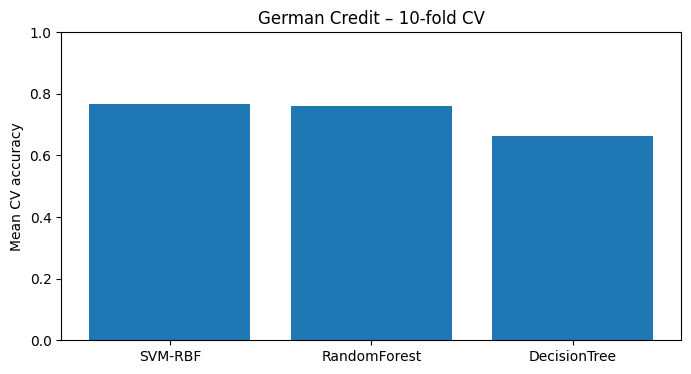

In [5]:
#===SOLUTION===

german_task   = openml.tasks.get_task(31)
german_X, german_y = german_task.get_X_and_y(dataset_format="dataframe")

learners = {
    "DecisionTree":   DecisionTreeClassifier(random_state=42),
    "RandomForest":   RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "SVM-RBF":        SVC(kernel="rbf", probability=True, random_state=42),
}

ct = ColumnTransformer(
    [
        (
            "numeric", 
            Pipeline(
                [("impute", SimpleImputer(strategy="mean")), ("scale", StandardScaler())]
            ), 
            make_column_selector(dtype_include=np.number),
        ),
        ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), make_column_selector(dtype_exclude=np.number)),
    ]
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def evaluate(name, estimator, X, y, cv):
    """Run 10-fold CV and return the mean accuracy for one learner."""
    pipeline = Pipeline(
        [
            ("transformer", clone(ct)),
            ("estimator", estimator)
        ]
    )
    res = cross_validate(
        pipeline, X, y,
        cv=cv,
        n_jobs=-1,           # will be ignored because of n_jobs=-1 below
        scoring="accuracy",
        return_train_score=False
    )
    return {"learner": name, "accuracy": res["test_score"].mean()}

# Outer-loop parallelisation: run learners side-by-side
results = Parallel(n_jobs=-1)(
    delayed(evaluate)(name, est, german_X, german_y, cv)
    for name, est in learners.items()
)
results_df = pd.DataFrame(results).sort_values("accuracy", ascending=False)
print(results_df)

plt.figure(figsize=(8, 4))
plt.bar(results_df["learner"], results_df["accuracy"])
plt.ylabel("Mean CV accuracy")
plt.title("German Credit – 10-fold CV")
plt.ylim(0, 1)
plt.show()

Obviously, this code could be optimized further, for example:

1. evaluate every fold in parallel
2. evaluate multiple datasets in parallel
3. replace `joblib.Parallel` by a more versatile scheduler that allows retrieving intermediate results to persist them on disk
4. run in parallel across multiple machines, for example, using the [dask library](https://joblib.readthedocs.io/en/latest/auto_examples/parallel/distributed_backend_simple.html) or the [pyexperimenter](https://github.com/tornede/py_experimenter)

# 4. Fully parallel

No, implement improvement one and two from above: extend the function to take the dataset and the fold number as argument

In [6]:
import itertools

import openml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config, clone
from sklearn.metrics import accuracy_score

set_config(transform_output="pandas")

In [7]:
#===SOLUTION===

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
task_ids = (31, 20)
openml.populate_cache(task_ids=task_ids)

def evaluate(name, estimator, task_id, cv, fold_number):
    german_task   = openml.tasks.get_task(task_id)
    X, y = german_task.get_X_and_y(dataset_format="dataframe")
    """Run 10-fold CV and return the mean accuracy for one learner."""
    pipeline = Pipeline(
        [
            ("transformer", clone(ct)),
            ("estimator", estimator)
        ]
    )
    for fold_idx, (train_idx, valid_idx) in enumerate(cv.split(X=X, y=y)):
        
        if fold_idx != fold_number:
            continue
        
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_valid = X.iloc[valid_idx]
        y_valid = y.iloc[valid_idx]

        pipeline.fit(X_train, y_train)
        y_hat = pipeline.predict(X_valid)
        
        return {"learner": name, "accuracy": accuracy_score(y_valid, y_hat), "task_id": task_id}

# Outer-loop parallelisation: run learners side-by-side
results = Parallel(n_jobs=-1)(
    delayed(evaluate)(name, est, task_id, cv, fold_number)
    for task_id, (name, est), fold_number in itertools.product(task_ids, learners.items(), range(10))
)
results_df = pd.DataFrame(results).groupby(["task_id", "learner"]).mean("accuracy")
print(results_df)

                      accuracy
task_id learner               
20      DecisionTree    0.8775
        RandomForest    0.9735
        SVM-RBF         0.9760
31      DecisionTree    0.6630
        RandomForest    0.7620
        SVM-RBF         0.7680


# 5. Summary

* **openml-python** replaces `mlr3oml` for task discovery and dataset retrieval.
* **scikit-learn** models stand in for mlr3 learners.
* **joblib** gives you painless multicore execution both:

  * **inside** each `cross_validate` call (`n_jobs=-1`), and
  * **outside** when dispatching different learners/tasks in parallel.

You now have a fully Pythonic, laptop-friendly template for large-scale benchmarking that mirrors the structure and pedagogical intent of the original R exercise. 